# Model de rayonnement diffus

Utilisons des outils d'analyse statistique sur le jeu de données

In [1]:
import pandas as pd
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pvlib

In [2]:
filename = '../Penn_State_PA_2012.gzip'
df = pd.read_csv(filename, encoding='utf-8', compression='gzip', index_col='timestamp', parse_dates=True)
df.index = df.index.tz_localize('UTC').tz_convert('US/Eastern')

In [3]:
col_flag = df.columns[df.columns.str.endswith('_Flag')]
col_noflag = col_flag.str.replace('_Flag', '')
for i in col_noflag.values:
    df.loc[df[i + '_Flag'] > 0, i] = np.nan

## Model de rayonnement diffus

#### Creation des valeurs de rayonnement total, extra-terrestre, de k_T et Diffus/Global

In [4]:
df['G_o'] = pvlib.irradiance.extraradiation(df.index.dayofyear) * np.cos(np.deg2rad(df.zen))
df['G'] = df.direct_n * np.cos(np.deg2rad(df.zen)) + df.diffuse
df.loc[df.zen > 90,'G'] = np.nan # Remove values when sun is bellow horizon
df['k_T'] = df.G / df.G_o
df['Id_I'] = df.diffuse / df.G
df.loc[df['k_T'] <= 0,'k_T'] = np.nan

#### Moyenne journalière

In [5]:
dailydata = df.loc[df.G_o > 90].resample('D', convention='end', closed='right').mean()
dailydata['k_T'] = dailydata.G / dailydata.G_o
dailydata['Id_I'] = dailydata.diffuse / dailydata.G

#### Moyenne horaire

In [6]:
hourdata = df.resample('H', convention='end', closed='right').mean()
hourdata['k_T'] = hourdata.G / hourdata.G_o
hourdata['Id_I'] = hourdata.diffuse / hourdata.G

#### Modèle de Erbs

In [7]:
# Empirical Solution
kt = np.linspace(0, 1, 100000)[:, None]

# For Kt <= 0.22, set the diffuse fraction
ds = 1 - 0.09*kt

# For Kt > 0.22 and Kt <= 0.8, set the diffuse fraction
ds = np.where((kt > 0.22) & (kt <= 0.8),
              0.9511 - 0.1604*kt + 4.388*kt**2 -
              16.638*kt**3 + 12.336*kt**4,
              ds)

# For Kt > 0.8, set the diffuse fraction
ds = np.where(kt > 0.8, 0.165, ds)

### Graph des trois résolutions de données (minute, horaire, journalière)

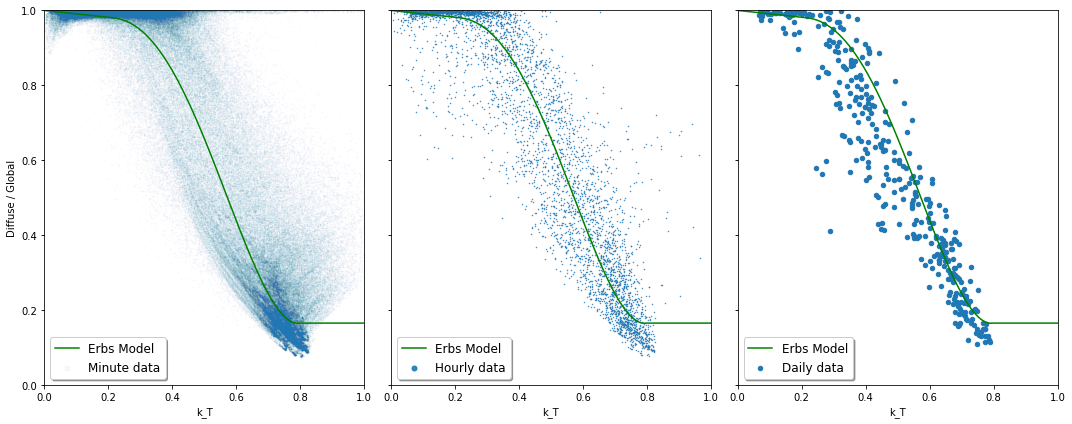

In [8]:
# Plot
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,6), sharex=True, sharey=True)

df.loc[df.G_o > 0].plot.scatter(x = 'k_T', y = 'Id_I', xlim=[0,1], ylim=[0,1],
                                alpha = 0.04, s=0.25, ax=ax1, label='Minute data')
ax1.set_ylabel('Diffuse / Global')
ax1.plot(kt, ds, 'g', label='Erbs Model')
legend = ax1.legend(loc='lower left', shadow=True, fontsize='large', markerscale = 10)

hourdata.loc[hourdata.G_o > 0].plot.scatter(x = 'k_T', y = 'Id_I',
                                            xlim=[0,1],ylim=[0,1], alpha = 0.9, s=0.25, ax=ax2,
                                            label='Hourly data')
ax2.set_ylabel('Diffuse / Global')
ax2.plot(kt, ds, 'g', label='Erbs Model')
legend = ax2.legend(loc='lower left', shadow=True, fontsize='large', markerscale = 10)

dailydata.loc[dailydata.G_o > 0].plot.scatter(x = 'k_T', y = 'Id_I',
                                              xlim=[0,1],ylim=[0,1], alpha = 1, ax=ax3,
                                              label='Daily data')
ax3.set_ylabel('Diffuse / Global')
ax3.plot(kt, ds, 'g', label='Erbs Model')
legend = ax3.legend(loc='lower left', shadow=True, fontsize='large', markerscale = 1)
fig.tight_layout()